In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import scienceplots as scp

import numpy as np
import torch

matplotlib.rcParams['figure.figsize'] = (20, 6)

import sys
sys.path.append("..")

from argparse import Namespace
from main import main, parse_args
from utils.plotting import *
from utils.analysis import process_outputs, get_change_responses, get_omission_responses

from utils.data import load_results_files

import warnings
warnings.filterwarnings('ignore')

import os

In [ ]:
import importlib 
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import *

In [ ]:
"""
active_files = [f for f in os.listdir(f"../results/main_model/") if f.startswith("perception_action")]

for f in active_files:

    file_path = os.path.join(f"../results/main_model/{f}")
    data = torch.load(file_path, map_location='cpu')

    omission_responses = data['omission_responses']
    familiar_resp = omission_responses['familiar']
    novel_resp = omission_responses['novel']

    familiar_means = {k: torch.zeros(v.shape[0], v.shape[-1], 3) for (k, v) in familiar_resp.items()}
    novel_means = {k: torch.zeros(v.shape[0], v.shape[-1], 3) for (k, v) in novel_resp.items()}

    for k in omission_responses['familiar'].keys():
        pre_window = (5, 8)
        omission_window = (8, 14)
        familiar_means[k][:, :, 0] = omission_responses["familiar"][k][:, pre_window[0]:pre_window[1]].mean(1)
        familiar_means[k][:, :, 1] = omission_responses["familiar"][k][:, omission_window[0]:omission_window[1]].mean(1)
        familiar_means[k][:, :, 2] = familiar_means[k][:, :, 1] - familiar_means[k][:, :, 0]
        novel_means[k][:, :, 0] = omission_responses["novel"][k][:, pre_window[0]:pre_window[1]].mean(1)
        novel_means[k][:, :, 1] = omission_responses["novel"][k][:, omission_window[0]:omission_window[1]].mean(1)
        novel_means[k][:, :, 2] = novel_means[k][:, :, 1] - novel_means[k][:, :, 0]
    
    omission_responses["familiar_means"] = familiar_means
    omission_responses["novel_means"] = novel_means

    data['omission_responses'] = omission_responses

    torch.save(data, file_path)
"""

In [2]:
# load results for the full model
active_args, active_change, active_omission, active_progress = load_results_files("../results/main_model", "perception_action")
active_args = Namespace(**active_args)

#### Change Responses

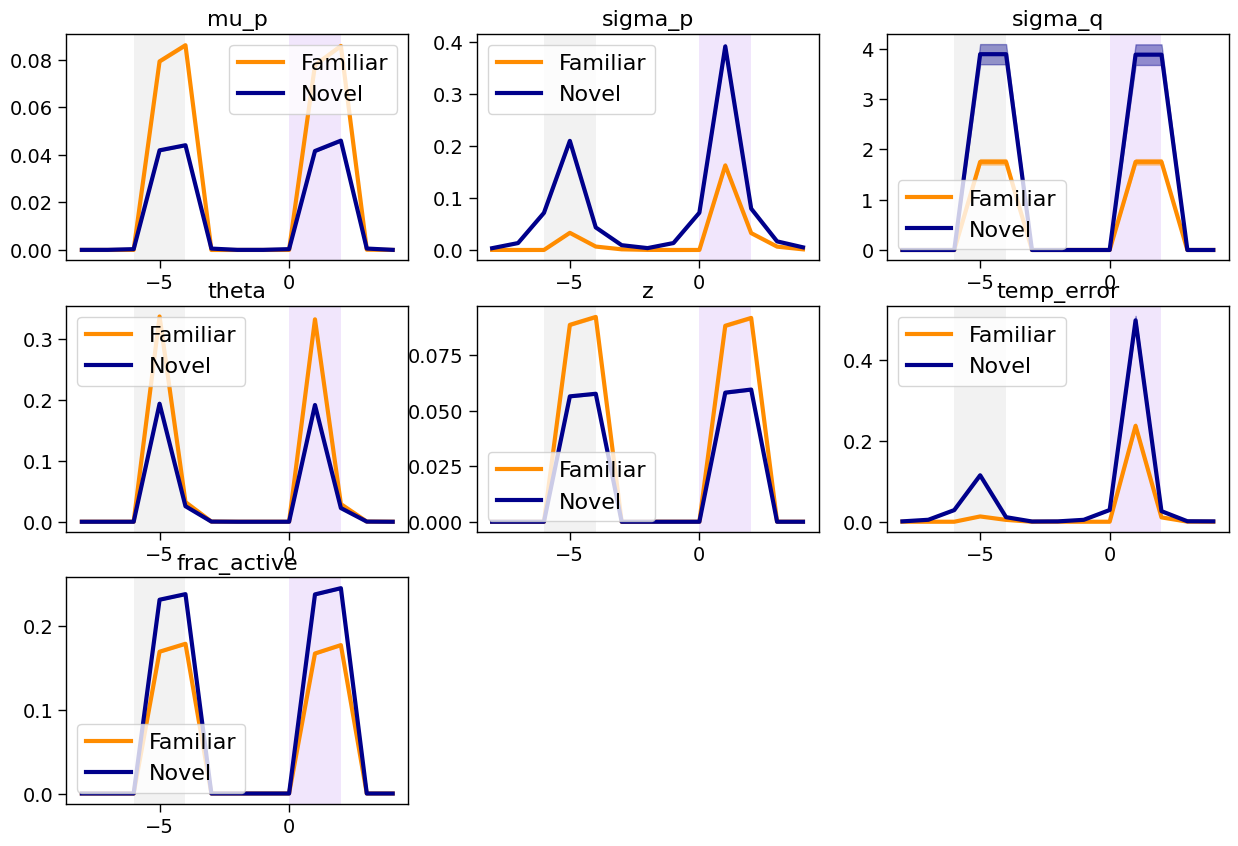

In [3]:
with plt.style.context(['nature', 'notebook']):

    change_fig = plt.figure(figsize=(15, 10))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(active_change['familiar'].keys()):
        ax = plt.subplot(3, 3, i+1)
        _ = plot_trial_responses(active_args, ax, active_change['familiar'][pop], active_change['novel'][pop], normalize=False)
        _ = ax.set_title(f"{pop}")
        _ = ax.legend()

In [ ]:
change_fig.savefig("../figures/figure_4/change_responses.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

##### Fraction active bar plot

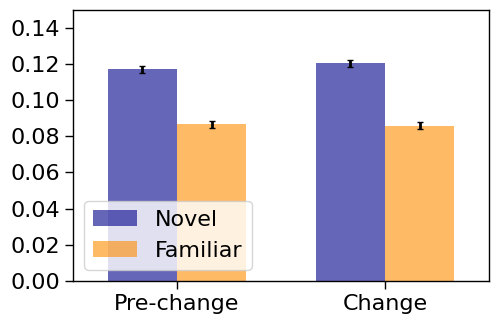

In [4]:
with plt.style.context(['nature', 'notebook']):

    fam_len, nov_len = len(active_change['familiar_means']['frac_active']), len(active_change['novel_means']['frac_active'])

    pre_fam, pre_fam_err = compute_population_stats(active_change['familiar_means']['frac_active'][..., 0].numpy(), alpha=0.000000001)
    pre_nov, pre_nov_err = compute_population_stats(active_change['novel_means']['frac_active'][..., 0].numpy(), alpha=0.000000001)
    change_fam, change_fam_err = compute_population_stats(active_change['familiar_means']['frac_active'][..., 1].numpy(), alpha=0.000000001)
    change_nov, change_nov_err = compute_population_stats(active_change['novel_means']['frac_active'][..., 1].numpy(), alpha=0.000000001)

    pre_fam_std = active_change['familiar_means']['frac_active'][..., 0].numpy().std() / np.sqrt(fam_len)
    pre_nov_std = active_change['novel_means']['frac_active'][..., 0].numpy().std() / np.sqrt(nov_len)
    change_fam_std = active_change['familiar_means']['frac_active'][..., 1].numpy().std() / np.sqrt(fam_len)
    change_nov_std = active_change['novel_means']['frac_active'][..., 1].numpy().std() / np.sqrt(nov_len)


    frac_fig, frac_ax = plt.subplots(figsize=(5, 3.33))

    frac_ax.bar(
        x = [1., 1.3],
        height=[pre_nov, change_nov],
        yerr=[pre_nov_err, change_nov_err],
        width=0.1,
        align='center',
        color=(NOV_CLR, NOV_CLR),
        alpha=0.6,
        capsize=2,
        label='Novel'
    )

    frac_ax.bar(
        x = [1.1, 1.4],
        height=[pre_fam, change_fam],
        yerr=[pre_fam_err, change_fam_err],
        width=0.1,
        align='center',
        color=(FAM_CLR, FAM_CLR),
        alpha=0.6,
        capsize=2,
        label='Familiar'
    )

    frac_ax.set_xticks([1.05, 1.35])
    frac_ax.set_xticklabels(['Pre-change', 'Change'])
    
    frac_ax.set_ylim([0., 0.15])
    frac_ax.set_xlim([0.9, 1.5])
    frac_ax.legend()

    plt.tight_layout()
    

In [ ]:
frac_fig.savefig("../figures/figure_4/frac_actives.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

#### Confidence Plots

##### Excitatory

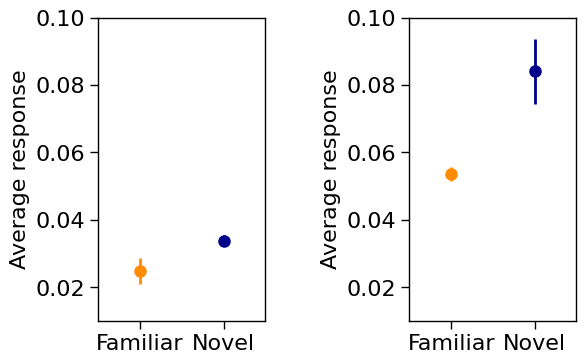

In [5]:
with plt.style.context(['nature', 'notebook']):

    fam_z = torch.concatenate([active_change['familiar_means']['z'], active_change['familiar_means']['temp_error']], dim=1)
    nov_z = torch.concatenate([active_change['novel_means']['z'], active_change['novel_means']['temp_error']], dim=1)
    
    exc_conf_fig, exc_conf = plt.subplots(1, 2, figsize=(7, 5))
    plt.tight_layout(pad=8, h_pad=5)

    # pre-change
    fam_pre = fam_z[..., 0].detach().mean(0)
    nov_pre = nov_z[..., 0].detach().mean(0)
    plot_confidence_intervals(exc_conf[0], fam_pre.numpy(), nov_pre.numpy())
    exc_conf[0].set_ylim([0.01, .1])

    # change
    fam_change = fam_z[..., 1].detach().mean(0)
    nov_change = nov_z[..., 1].detach().mean(0)
    plot_confidence_intervals(exc_conf[1], fam_change.numpy(), nov_change.numpy())
    exc_conf[1].set_ylim([0.01, .1])

##### SST

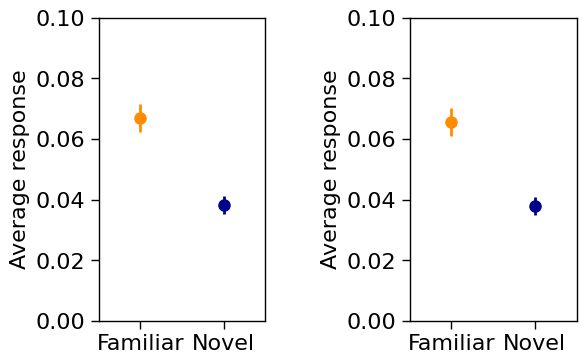

In [6]:
with plt.style.context(['nature', 'notebook']):

    fam_z = torch.concatenate([active_change['familiar_means']['theta'], active_change['familiar_means']['mu_p']], dim=1)
    nov_z = torch.concatenate([active_change['novel_means']['theta'], active_change['novel_means']['mu_p']], dim=1)
    
    sst_conf_fig, sst_conf = plt.subplots(1, 2, figsize=(7, 5))
    plt.tight_layout(pad=8, h_pad=5)

    # pre-change
    fam_pre = fam_z[..., 0].detach().mean(0)
    nov_pre = nov_z[..., 0].detach().mean(0)
    plot_confidence_intervals(sst_conf[0], fam_pre.numpy(), nov_pre.numpy())
    sst_conf[0].set_ylim([0., .1])

    # change
    fam_change = fam_z[..., 1].detach().mean(0)
    nov_change = nov_z[..., 1].detach().mean(0)
    plot_confidence_intervals(sst_conf[1], fam_change.numpy(), nov_change.numpy())
    sst_conf[1].set_ylim([0., .1])

##### VIP

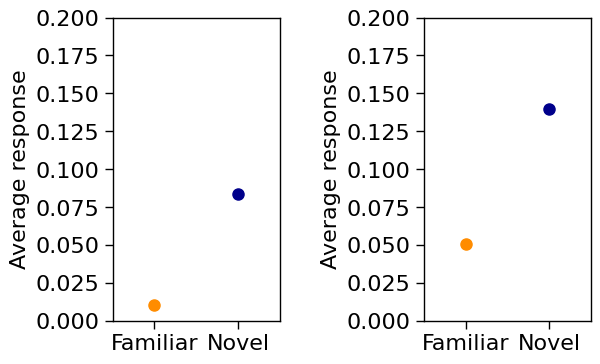

In [7]:
with plt.style.context(['nature', 'notebook']):

    fam_z = active_change['familiar_means']['sigma_p']
    nov_z = active_change['novel_means']['sigma_p']
    
    vip_conf_fig, vip_conf = plt.subplots(1, 2, figsize=(7, 5))
    plt.tight_layout(pad=8, h_pad=5)

    # pre-change
    fam_pre = fam_z[..., 0].detach().mean(0)
    nov_pre = nov_z[..., 0].detach().mean(0)
    plot_confidence_intervals(vip_conf[0], fam_pre.numpy(), nov_pre.numpy())
    vip_conf[0].set_ylim([0., .2])

    # change
    fam_change = fam_z[..., 1].detach().mean(0)
    nov_change = nov_z[..., 1].detach().mean(0)
    plot_confidence_intervals(vip_conf[1], fam_change.numpy(), nov_change.numpy())
    vip_conf[1].set_ylim([0., .2])

In [8]:
exc_conf_fig.savefig("../figures/figure_4/exc_conf.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
sst_conf_fig.savefig("../figures/figure_4/sst_conf.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
vip_conf_fig.savefig("../figures/figure_4/vip_conf.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

#### Omission Responses

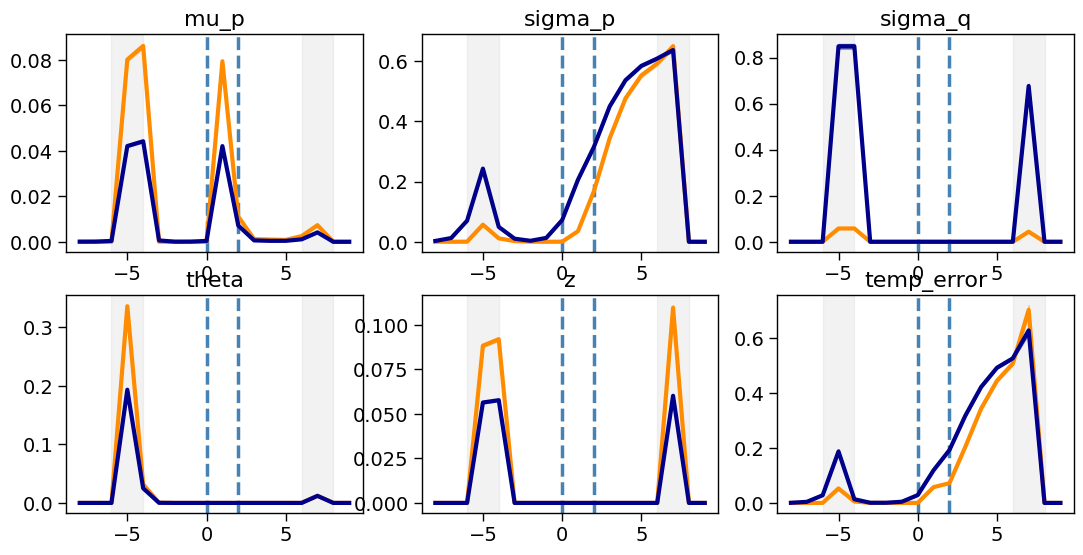

In [24]:
##### plot responses around omissions

with plt.style.context(['nature', 'notebook']):

    omission_fig = plt.figure(figsize=(13, 13))
    #plt.tight_layout(pad=19, h_pad=15)

    for i, pop in enumerate(active_omission['familiar'].keys()):
        ax = plt.subplot(4, 3, i+1)
        plot_trial_responses(active_args, ax, active_omission['familiar'][pop], active_omission['novel'][pop], trial_mode='omission', normalize=False)
        _ = ax.set_title(f"{pop}")

In [25]:
omission_fig.savefig("../figures/figure_4/omission_responses.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

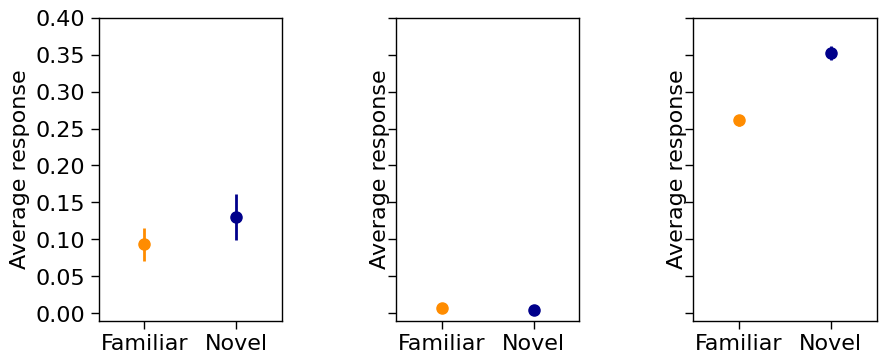

In [18]:
with plt.style.context(['nature', 'notebook']):

    e_fam = torch.concatenate([active_omission['familiar_means']['z'], active_omission['familiar_means']['temp_error']], dim=1)
    e_nov = torch.concatenate([active_omission['novel_means']['z'], active_omission['novel_means']['temp_error']], dim=1)

    sst_fam = torch.concatenate([active_omission['familiar_means']['theta'], active_omission['familiar_means']['mu_p']], dim=1)
    sst_nov = torch.concatenate([active_omission['novel_means']['theta'], active_omission['novel_means']['mu_p']], dim=1)

    vip_fam = active_omission['familiar_means']['sigma_p']
    vip_nov = active_omission['novel_means']['sigma_p']
    
    om_conf_fig, om_conf = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
    plt.tight_layout(pad=8, h_pad=5)

    # excitatory
    e_fam_mean = e_fam[..., 2].detach().mean(0)
    e_nov_mean = e_nov[..., 2].detach().mean(0)
    plot_confidence_intervals(om_conf[0], e_fam_mean.numpy(), e_nov_mean.numpy(), alpha=0.01)
    om_conf[0].set_ylim([-0.01, .4])

    # sst
    sst_fam_mean = sst_fam[..., 2].detach().mean(0)
    sst_nov_mean = sst_nov[..., 2].detach().mean(0)
    plot_confidence_intervals(om_conf[1], sst_fam_mean.numpy(), sst_nov_mean.numpy(), alpha=0.01)

    # vip
    vip_fam_mean = vip_fam[..., 2].detach().mean(0)
    vip_nov_mean = vip_nov[..., 2].detach().mean(0)
    plot_confidence_intervals(om_conf[2], vip_fam_mean.numpy(), vip_nov_mean.numpy(), alpha=0.01)


In [19]:
om_conf_fig.savefig("../figures/figure_4/omission_conf.pdf", dpi=600, bbox_inches="tight", pad_inches=0)